In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from models.resnet_model import MalariaResNet50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MalariaResNet50(num_classes=2).to(device)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Confiurations
DATA_DIR = 'malaria_ds/split_dataset'
MODEL_SAVE_PATH = 'models/malaria_model.pth'

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4

Parasitized Images: 13779
Uninfected Images: 13779


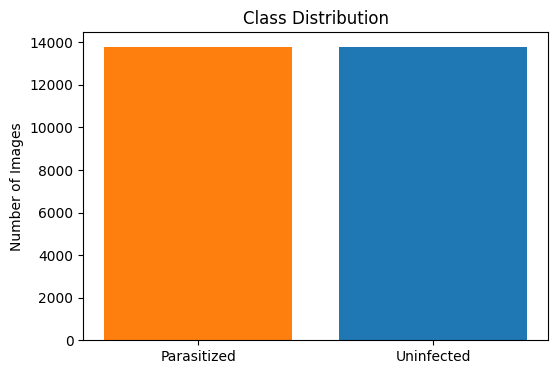

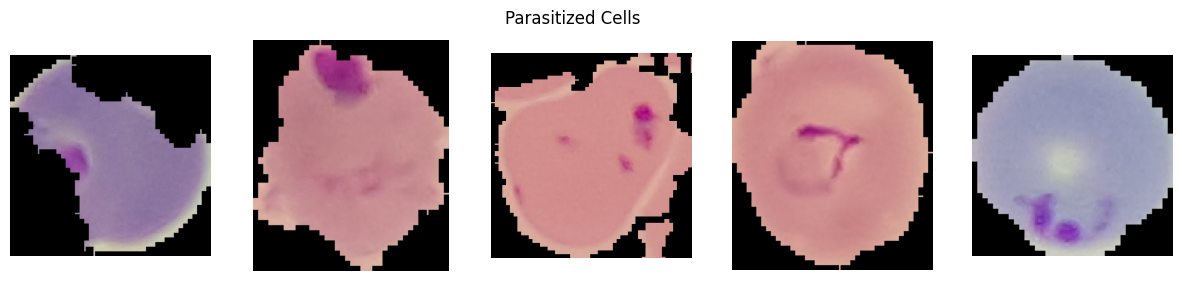

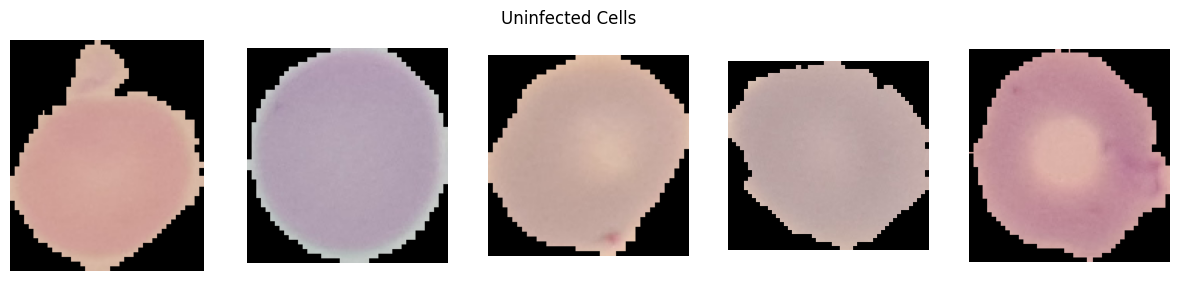

Unique image sizes found:
{(166, 181), (226, 232), (70, 64), (124, 184), (130, 115), (88, 118), (202, 103), (139, 163), (205, 145), (163, 148), (121, 151), (172, 196), (79, 154), (193, 139), (196, 181), (94, 133), (154, 184), (193, 175), (112, 187), (157, 109), (127, 166), (187, 217), (79, 46), (190, 142), (109, 154), (223, 139), (148, 145), (160, 199), (142, 187), (181, 178), (145, 112), (103, 115), (175, 220), (160, 91), (220, 142), (118, 94), (178, 145), (115, 205), (76, 97), (289, 241), (136, 148), (100, 82), (151, 127), (169, 181), (175, 112), (73, 64), (133, 115), (130, 226), (91, 118), (106, 97), (166, 148), (124, 151), (88, 85), (139, 130), (205, 112), (97, 133), (157, 184), (163, 115), (121, 118), (172, 163), (97, 169), (190, 217), (196, 148), (94, 100), (154, 151), (172, 199), (193, 142), (112, 154), (94, 136), (127, 133), (187, 184), (145, 187), (109, 121), (127, 169), (148, 112), (178, 220), (184, 151), (142, 154), (181, 145), (217, 184), (82, 139), (142, 190), (103, 82), (

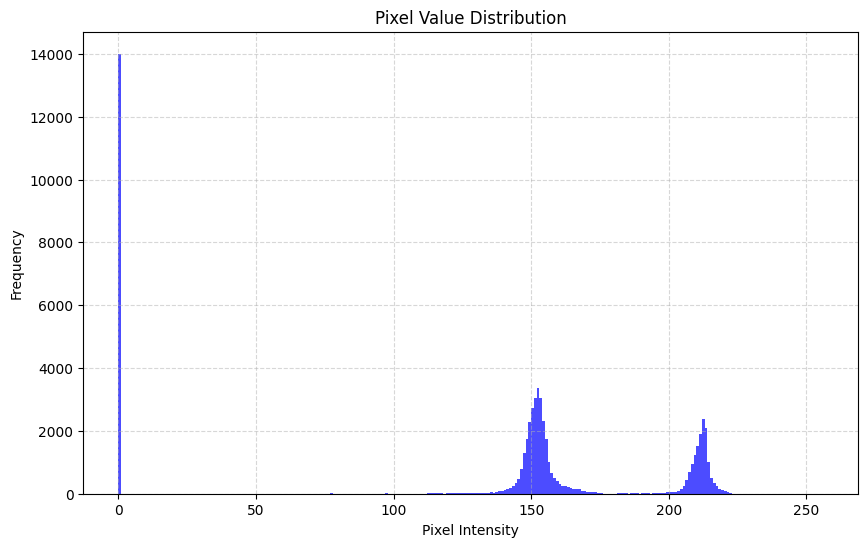

Splitting Parasitized Images:
Parasitized -> Train: 11024, Val: 1378, Test: 1378

Splitting Uninfected Images:
Uninfected -> Train: 11024, Val: 1378, Test: 1378

Total Classes: 2
Train batches: 689, Val batches: 87, Test batches: 87


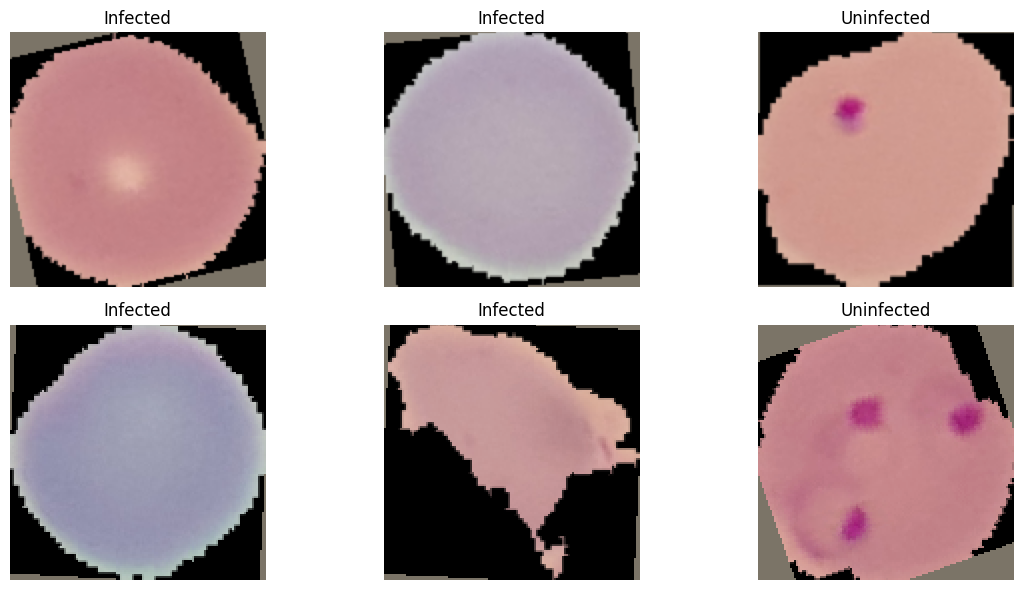


Total Classes: 2
Train batches: 689, Val batches: 87, Test batches: 87


In [6]:
# Import loader from data_prep
from data_prep import get_dataloaders

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_dataloaders()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
def train_model(model, num_epochs=EPOCHS):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct_preds += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct_preds.double() / len(train_dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        running_loss_val = 0.0
        correct_preds_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * inputs.size(0)
                correct_preds_val += torch.sum(preds == labels.data)

        val_loss = running_loss_val / len(val_dataset)
        val_acc = correct_preds_val.double() / len(val_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model.save(MODEL_SAVE_PATH)
            print("Saved Best Model!")

    print("\nTraining Complete")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
train_losses, val_losses, train_accs, val_accs = train_model(model, EPOCHS)


Epoch 1/10
----------


Training: 100% 689/689 [00:45<00:00, 15.21it/s]


Train Loss: 0.1241 Acc: 0.9567


Validating: 100% 87/87 [00:02<00:00, 33.73it/s]


Val Loss: 0.1008 Acc: 0.9630
Model saved to models/malaria_model.pth
Saved Best Model!

Epoch 2/10
----------


Training: 100% 689/689 [00:43<00:00, 15.66it/s]


Train Loss: 0.0929 Acc: 0.9683


Validating: 100% 87/87 [00:02<00:00, 35.12it/s]


Val Loss: 0.0825 Acc: 0.9702
Model saved to models/malaria_model.pth
Saved Best Model!

Epoch 3/10
----------


Training: 100% 689/689 [00:44<00:00, 15.55it/s]


Train Loss: 0.0851 Acc: 0.9702


Validating: 100% 87/87 [00:02<00:00, 35.04it/s]


Val Loss: 0.0839 Acc: 0.9699

Epoch 4/10
----------


Training: 100% 689/689 [00:44<00:00, 15.64it/s]


Train Loss: 0.0798 Acc: 0.9721


Validating: 100% 87/87 [00:02<00:00, 34.64it/s]


Val Loss: 0.0806 Acc: 0.9699

Epoch 5/10
----------


Training: 100% 689/689 [00:44<00:00, 15.62it/s]


Train Loss: 0.0756 Acc: 0.9731


Validating: 100% 87/87 [00:02<00:00, 34.38it/s]


Val Loss: 0.0804 Acc: 0.9713
Model saved to models/malaria_model.pth
Saved Best Model!

Epoch 6/10
----------


Training: 100% 689/689 [00:43<00:00, 15.79it/s]


Train Loss: 0.0694 Acc: 0.9756


Validating: 100% 87/87 [00:02<00:00, 35.86it/s]


Val Loss: 0.0842 Acc: 0.9706

Epoch 7/10
----------


Training: 100% 689/689 [00:43<00:00, 15.74it/s]


Train Loss: 0.0676 Acc: 0.9757


Validating: 100% 87/87 [00:02<00:00, 35.05it/s]


Val Loss: 0.0819 Acc: 0.9710

Epoch 8/10
----------


Training: 100% 689/689 [00:43<00:00, 15.71it/s]


Train Loss: 0.0637 Acc: 0.9772


Validating: 100% 87/87 [00:02<00:00, 36.10it/s]


Val Loss: 0.0785 Acc: 0.9731
Model saved to models/malaria_model.pth
Saved Best Model!

Epoch 9/10
----------


Training: 100% 689/689 [00:43<00:00, 15.67it/s]


Train Loss: 0.0614 Acc: 0.9775


Validating: 100% 87/87 [00:02<00:00, 35.27it/s]


Val Loss: 0.0867 Acc: 0.9717

Epoch 10/10
----------


Training: 100% 689/689 [00:43<00:00, 15.72it/s]


Train Loss: 0.0600 Acc: 0.9795


Validating: 100% 87/87 [00:02<00:00, 34.39it/s]

Val Loss: 0.0796 Acc: 0.9717

Training Complete


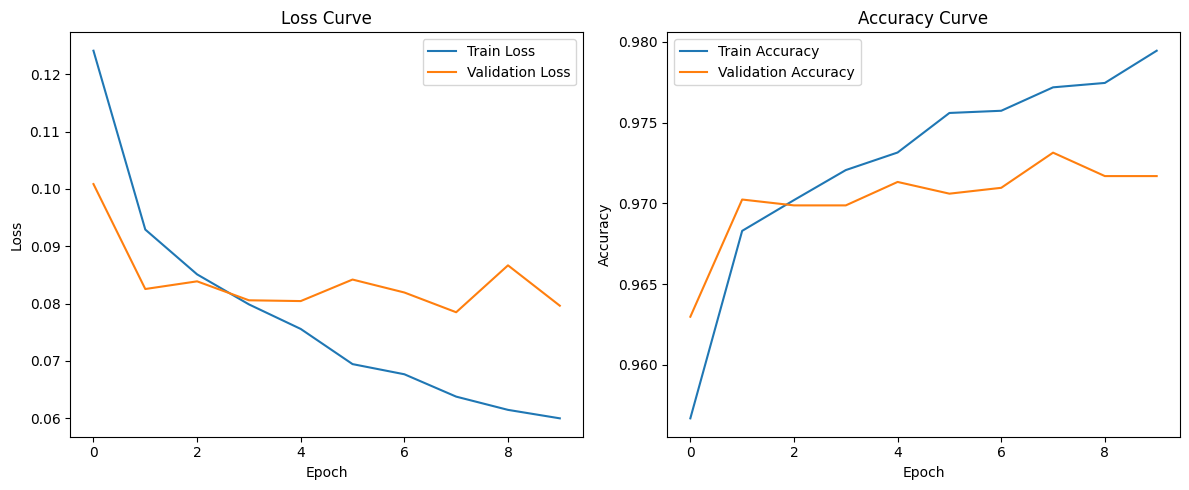

In [10]:
# Plot Training Metrics
# -----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()